In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
from numba import jit 

sys.path.insert(0, "../../")
sys.path.insert(0, "/home/noah/Dropbox/gnl")

from gnl.plots import *
from gnl.xarray import *

sys.path.insert(0, "../../")

from python.read import read_data

data = read_data("./data")

this is the damping timescale used in the multicloud model

In [14]:
ud = .12
1/ud * 8.3/24

2.8819444444444446

It appears that the efolding timescale is about 3 days.

Now we want to plot the climatology of all variables to find a variable which selects for wave activity on the flanks of the warm-pool.

## Warm pool transition rates

In [15]:
from python.cmt import run_cmt_model, calc_du, heaviside, T, alpha_bar, c, hour,day
from python import cmt

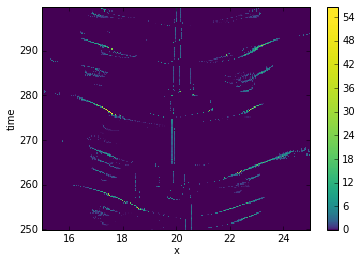

In [16]:
from gnl.plots import LogP1
import xarray as xr


n = data['hd'].shape[1]
x  = np.linspace(0, 40, n)
time = data['time']


def scalar_darray(data, x=x, time=time):
    data = xr.DataArray(data, dims=('time', 'x'), 
                  coords={'time':time, 'x': x})
    
    return remove_repeats(data)



hd = scalar_darray(data['hd']) * alpha_bar / (24/8.3)

hc = scalar_darray(data['hc']) * alpha_bar / (24/8.3)

warmpool_range= dict(time=slice(250, None), x=slice(15, 25))

hd.sel(**warmpool_range)\
            .plot(norm=LogP1(base=4))

The warm pool region is saturated with upscale cmt

In [17]:
uz = cmt.transform_mat[32].dot(data['u'])
z = cmt.z /np.pi * 16

uza = xr.DataArray(uz, dims=['z', 'time', 'x'], coords={'x':x, 'time':time, 'z':z }) * cmt.c



dulo_a = scalar_darray([calc_du(u)[0] for u in data['u']])

Here I threshold teb -tem  qt different quantiles to see, which level of lmd most effectively selects large convectively coupled waves.

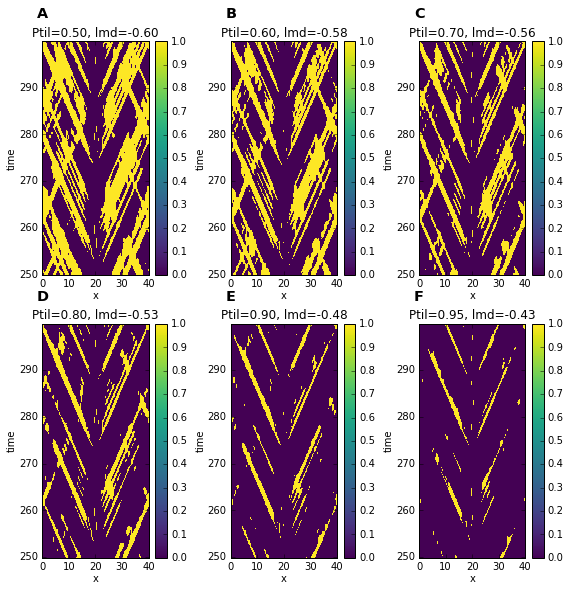

In [18]:
from gnl.plots import *

lmd = scalar_darray(data['lmd'])    
df = lmd.sel(time=slice(100, None)).to_dataframe(name='lmd')

for val in plotiter([.5, .6, .7, .8, .9, .95], figsize=(8,8)):
    (lmd > df.lmd.quantile(val)).sel(time=slice(250,None)).plot()
    plt.title("Ptil={:.2f}, lmd={:.2f}".format(val, df.lmd.quantile(val)))
plt.tight_layout()

Here I plot some reasonable neural network style transitions matrices

In [19]:
tr1 = cmt.tr1

t , scmt = cmt.stochastic_cmt_diagnostic_run("data", f=tr1)

scmt = scalar_darray(scmt)



/scratch/noah/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:552: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
../../python/cmt.py:256: RuntimeWarning: invalid value encountered in less
  mask = time[running] < b


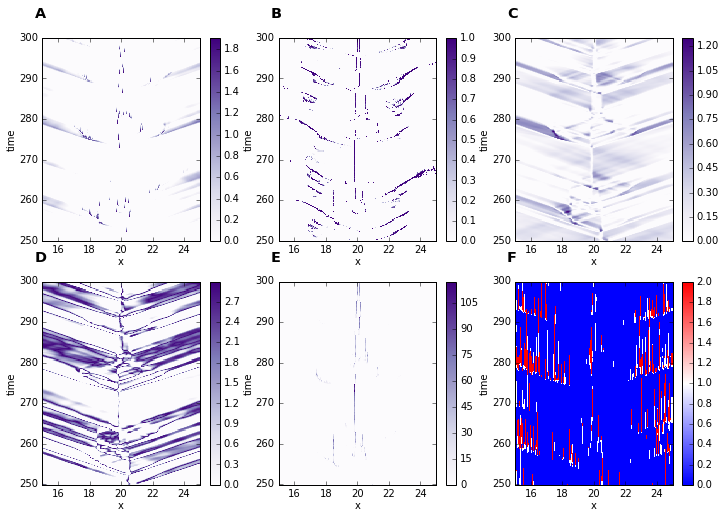

In [37]:
@jit
def softmax(x):
    return (np.abs(x) + x)/2

tanh = np.tanh

a = ((lmd + .5) + np.abs(lmd+.5))/2
pt = plotiter(range(6), w=4)


100
next(pt)
(4*softmax(lmd+.5)).sel(**warmpool_range).plot(cmap='Purples')

next(pt)
tanh(softmax(hd)).sel(**warmpool_range).plot(cmap='Purples')

next(pt)
softmax(abs(dulo_a)-.3).sel(**warmpool_range).plot(cmap='Purples')


next(pt)
(10*softmax(.3 - abs(dulo_a))).sel(**warmpool_range).plot(cmap='Purples')

next(pt)
softmax(hc).sel(**warmpool_range).plot(cmap='Purples')

next(pt)
scmt.sel(**warmpool_range).plot(cmap='bwr')

plt.savefig("../../../multicmt/doc/2016-10-24/activation_funcs.png")

These variables can be hand tuned to create plausible transition rates. However, a more rigorous approach would use a machine learning algorithm to select these parameters.